### W tej części zajmiemy się wydzielaniem poszczególnych znaków z tablicy rejestracyjnej

In [28]:
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import grid
from torchvision.transforms.functional import rgb_to_grayscale
import cv2
from skimage import measure 
import imutils 
import matplotlib.patches as patches
from IPython.display import Image
import torchvision 
import torch
from PIL import Image
from torchvision.utils import make_grid

### Wstawiamy ściężkę naszego obrazu do tablicy, obraz musi być rozmiarów 100x100 pixeli tak jak w modelu YOLO.

In [29]:
ii2 = cv2.imread('C:\\Users\\Tomasz\\Desktop\\Projekt\\cropped_box0.jpg')

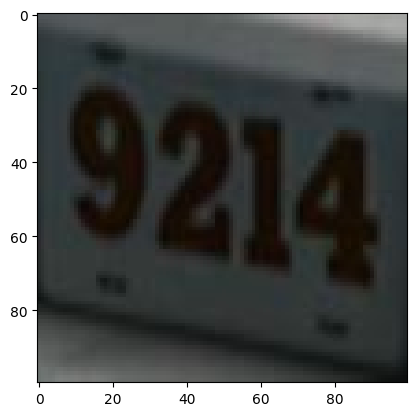

In [30]:
img2 = np.array(ii2)
plt.imshow(img2)

### Definiujemy funkcję segment_chars, która będzie miała za zadanie wykryć na naszym obrazie obszary, w których znajdują się cyfry lub litery.

In [31]:
def segment_chars(plate_img): 
    
    # konwertujemy obraz na skalę szarości i wybieramy kanał 2 czyli jasność
    V = cv2.split(cv2.cvtColor(plate_img, cv2.COLOR_BGR2HSV))[2] 
    
    # funkcja adaptiveThreshold określa próg dla piksela na podstawie małego obszaru wokół niego. 
    thresh = cv2.adaptiveThreshold(V, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) 
    
    # obracamy obraz binarny (białe na czarne, czarne na białe)
    thresh = cv2.bitwise_not(thresh) 

    # etykietujemy wszystkie grupy białych pikseli przypisując im unikalne wartości, czarne piksele pozostają jako tło
    labels = measure.label(thresh, background = 0) 
    
    # Inicjalizujemy puste listy i tablicę, które będą przechowywać informacje o wykrytych znakach.
    charCandidates = np.zeros(thresh.shape, dtype ='uint8') 
    characters = [] 
    BoxXX = []
    BoxXY = []
    BoxXW = []
    BoxXH = []
    
    # przetwarzamy każdą etykietowaną grupę pikseli, tworzymy dla niej maskę, znajdujemy największy kontur w masce, obliczamy prostokąt otaczający 
    # ten kontur, a następnie przechowujemy współrzędne i wymiary tego prostokąta w odpowiednich listach
    for label in np.unique(labels): 
        if label == 0: 
            continue
    
        labelMask = np.zeros(thresh.shape, dtype ='uint8') 
        labelMask[labels == label] = 255
        cnts = cv2.findContours(labelMask,  cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_SIMPLE) 
        cnts = cnts[1] if imutils.is_cv3() else cnts[0] 
        if len(cnts) > 0: 
            c = max(cnts, key = cv2.contourArea) 
            (boxX, boxY, boxW, boxH) = cv2.boundingRect(c) 
        BoxXX.append(boxX)
        BoxXY.append(boxY)
        BoxXW.append(boxW)
        BoxXH.append(boxH)

    # Filtrujemy wykryte prostokąty na podstawie ich proporcji i rozmiarów, aby odrzucić te, które są zbyt małe, 
    # zbyt duże lub mają niewłaściwe proporcje (nie przypominają liter/cyfr)
    position = []      
    for contour in range(len(BoxXX)):
        if (BoxXW[contour]/float(BoxXH[contour])<1.0):
            if ((BoxXW[contour]<5) or (BoxXH[contour]> 95 or BoxXH[contour] < 30)):
                continue 
            else:
                position.append(contour)

    # Sortujemy współrzędne prostokątów wzdłuż osi X, aby zapewnić odpowiednią kolejność znaków (od lewej do prawej).
    PositionX = [] 
    PositionY = []
    PositionW = []
    PositionH = []

    PositionXF = [] 
    PositionYF = []
    PositionWF = []
    PositionHF = []
    
    for i in position:
        PositionX.append(BoxXX[i])
        PositionY.append(BoxXY[i])
        PositionW.append(BoxXW[i])
        PositionH.append(BoxXH[i])

    
    indx = np.argsort(PositionX)
    for i in range(len(indx)):
        ind = np.argsort(PositionX)[i]
        PositionXF.append(PositionX[ind])
        PositionYF.append(PositionY[ind])
        PositionWF.append(PositionW[ind])
        PositionHF.append(PositionH[ind])

    # Sprawdzamy czy znaleziono jakiekolwiek znaki
    if (len(PositionXF) == 0):
        print('Nie znaleziono znaków')

    # zwracamy wynik
    return PositionXF, PositionYF, PositionWF, PositionHF


### Wywołujemy funkcję segment_chars i przypisujemy jej wyniki do zmiennych

In [32]:
BoxXX, BoxXY, BoxXW, BoxXH = segment_chars(img2)

### Rysujemy prostokąty otaczające znaki na naszym obrazie

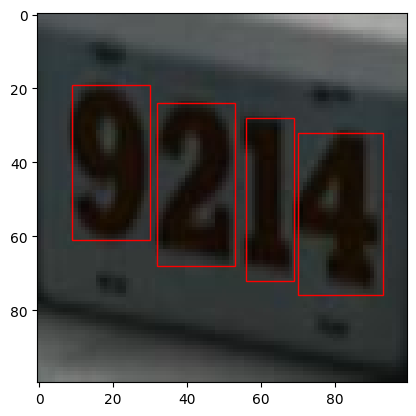

In [33]:
fig, ax = plt.subplots()
ax.imshow(img2)

for contour in range(len(BoxXX)):
    rect = patches.Rectangle((BoxXX[contour], BoxXY[contour]), BoxXW[contour], BoxXH[contour], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect) 

plt.show()

### Rysujemy poszczególne znaki z wyodrębnionych prostokątów i ujednolicamy do jednego rozmiaru

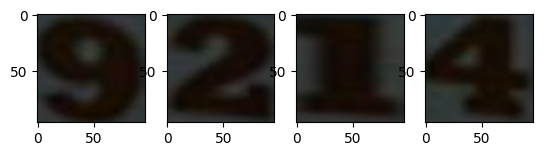

In [34]:
f, axarr = plt.subplots(1,len(BoxXX))
for indeks in reversed(range(len(BoxXX))):
    axarr[indeks].imshow(cv2.resize(img2[BoxXY[indeks]:(BoxXY[indeks]+BoxXH[indeks]),BoxXX[indeks]:(BoxXX[indeks]+BoxXW[indeks]),:], (96,96)))

### Definiujemy funkcję, która połączy nasze wyodrębnione prostokąty w jeden obraz

In [35]:
def box_to_image(img2, BoxXX, BoxXY, BoxXH, BoxXW):
    z = cv2.resize(img2[BoxXY[0]:(BoxXY[0]+BoxXH[0]),BoxXX[0]:(BoxXX[0]+BoxXW[0]),:], (96,96))
    for indeks in range(len(BoxXX)):
        i2 = cv2.resize(img2[BoxXY[indeks]:(BoxXY[indeks]+BoxXH[indeks]),BoxXX[indeks]:(BoxXX[indeks]+BoxXW[indeks]),:], (96,96))
        z = np.concatenate((z,i2),axis=1)
    return z[:,96:,:]

z = box_to_image(img2, BoxXX, BoxXY, BoxXH, BoxXW)

### Możemy wyrysować co dostaliśmy

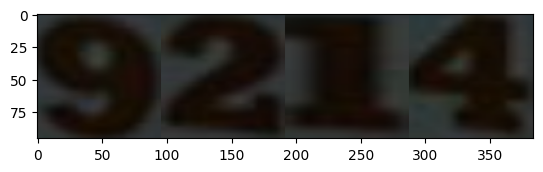

In [36]:
plt.imshow(box_to_image(img2, BoxXX, BoxXY, BoxXH, BoxXW))

### I na koniec zapisujemy nasz obraz, ponieważ będzie nam on potrzebny w dalszej części projektu

In [37]:
im = Image.fromarray(z)
im.save('C:\\Users\\Tomasz\\Desktop\\Projekt\\test.jpeg')